# Data Challenge 2: Fairness

### Authors:

#### Victor Ledez (victor.ledez@telecom-paris.fr)


<hr>

## 1. Import Libraries

<hr>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch.optim as optim
import torch.nn as nn
import torch

np.random.seed(seed=42)


<hr>

## 2. Reading Data

<hr>


In [2]:
def extract_labels(txt_file):
    with open(txt_file) as file:
        lines = file.readlines()
    y = []
    for elem in lines:
        label = int(elem[0])
        y.append(label)
    y = np.array(y)
    return y


In [3]:
X, y = np.load("train_data.npy"), extract_labels("train_labels.txt")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

X_train = torch.from_numpy(X_train).float()
X_valid = torch.from_numpy(X_valid).float()

y_train = torch.from_numpy(y_train).float().view(len(y_train), 1)
y_valid = torch.from_numpy(y_valid).float().view(len(y_valid), 1)


<hr>

## 3. Fully-connected Neural Network

<hr>


In [4]:
n_in = X_train.shape[1]
n_out = 1
n_h1 = round((n_in * 2 / 3) + n_out)
# n_h1 = 4 * n_in
# n_h2 = 3 * n_in
# n_h3 = 1 * n_in
nb_epoch = 100
alpha = 0.01

print(n_in)
print(n_h1)
# print(n_h2)
# print(n_h3)


96
65


In [5]:
my_model = nn.Sequential(
    nn.Linear(n_in, n_h1),
    nn.ReLU(),
    nn.Linear(n_h1, n_out),
    nn.Sigmoid()
)

# my_model = nn.Sequential(
#     nn.Linear(n_in, n_h1),
#     nn.ReLU(),
#     nn.Linear(n_h1, n_h2),
#     nn.ReLU(),
#     nn.Linear(n_h2, n_h3),
#     nn.ReLU(),
#     nn.Linear(n_h3, n_out),
#     nn.Sigmoid()
# )


epoch 0, loss 6.54854154586792
epoch 1, loss 44.60694122314453
epoch 2, loss 50.0
epoch 3, loss 50.0
epoch 4, loss 50.0
epoch 5, loss 50.0
epoch 6, loss 50.0
epoch 7, loss 50.0
epoch 8, loss 50.0
epoch 9, loss 50.0
epoch 10, loss 50.0
epoch 11, loss 50.0
epoch 12, loss 50.0
epoch 13, loss 50.0
epoch 14, loss 50.0
epoch 15, loss 50.0
epoch 16, loss 50.0
epoch 17, loss 50.0
epoch 18, loss 50.0
epoch 19, loss 50.0
epoch 20, loss 50.0
epoch 21, loss 50.0
epoch 22, loss 50.0
epoch 23, loss 50.0
epoch 24, loss 50.0
epoch 25, loss 50.0
epoch 26, loss 50.0
epoch 27, loss 50.0
epoch 28, loss 50.0
epoch 29, loss 50.0
epoch 30, loss 50.0
epoch 31, loss 50.0
epoch 32, loss 50.0
epoch 33, loss 50.0
epoch 34, loss 50.0
epoch 35, loss 50.0
epoch 36, loss 50.0
epoch 37, loss 50.0
epoch 38, loss 50.0
epoch 39, loss 50.0
epoch 40, loss 50.0
epoch 41, loss 50.0
epoch 42, loss 50.0
epoch 43, loss 50.0
epoch 44, loss 50.0
epoch 45, loss 50.0
epoch 46, loss 50.0
epoch 47, loss 50.0
epoch 48, loss 50.0
epoch

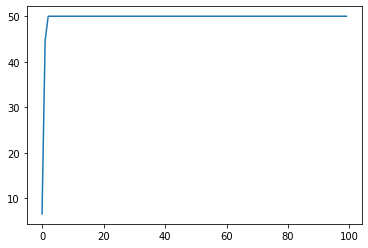

In [6]:
criterion = nn.BCELoss()
optimizer = optim.Adam(my_model.parameters(), lr=alpha)

loss_l = []
for num_epoch in range(nb_epoch):

    hat_y = my_model(X_train)
    loss = criterion(hat_y, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_l.append(loss.tolist())

    print(f'epoch {num_epoch}, loss {loss.item()}')

    if loss < 0.39:
        break

plt.plot(loss_l)


In [7]:
mask_males = (X_valid[:, 8] == X_valid[:, 56]) & (X_valid[:, 8] == 1)
mask_females = (X_valid[:, 8] == X_valid[:, 56]) & (X_valid[:, 8] == 0)


<hr>

## 4. Validating

<hr>


In [8]:
def criterion(y_pred, y_true):
    CM = confusion_matrix(y_true, y_pred)
    TN, TP = CM[0, 0], CM[1, 1]
    FP, FN = CM[0, 1], CM[1, 0]
    return 1 - (FP/(FP + TN) + FN/(FN + TP))


def fairness_criterion(y_pred, y_true, mask_males, mask_females):
    y_true_male = y_true[mask_males]
    y_true_female = y_true[mask_females]
    y_pred_male = y_pred[mask_males]
    y_pred_female = y_pred[mask_females]

    CM_m = confusion_matrix(y_true_male, y_pred_male)
    TN_m, TP_m = CM_m[0, 0], CM_m[1, 1]
    FP_m, FN_m = CM_m[0, 1], CM_m[1, 0]
    FNR_m = FN_m/(FN_m + TP_m)
    FPR_m = FP_m/(FP_m + TN_m)

    CM_f = confusion_matrix(y_true_female, y_pred_female)
    TN_f, TP_f = CM_f[0, 0], CM_f[1, 1]
    FP_f, FN_f = CM_f[0, 1], CM_f[1, 0]
    FNR_f = FN_f/(FN_f + TP_f)
    FPR_f = FP_f/(FP_f + TN_f)

    if min(FNR_m, FNR_f) == 0:
        if max(FNR_m, FNR_f) == 0:
            BFNR = 1
        else:
            BFNR = np.Infinity
    else:
        BFNR = max(FNR_m, FNR_f) / np.sqrt(FNR_m * FNR_f)

    if min(FPR_m, FPR_f) == 0:
        if max(FPR_m, FPR_f) == 0:
            BFPR = 1
        else:
            BFPR = np.Infinity
    else:
        BFPR = max(FPR_m, FPR_f) / np.sqrt(FPR_m * FPR_f)

    return BFPR, BFNR


In [9]:
y_pred = np.rint(my_model(X_valid).detach().numpy())
score_valid = criterion(y_pred, y_valid)
BFPR_valid, BFNR_valid = fairness_criterion(
    y_pred, y_valid, mask_males, mask_females)

print(f'FPR + FNR = {score_valid}')
print(f'Fairness scores: BFPR={BFPR_valid}, BFNR={BFNR_valid}')


FPR + FNR = 0.0
Fairness scores: BFPR=1, BFNR=1.0


<hr>

## 5. Score

<hr>


In [10]:
X_test = np.load("test_data.npy")

X_test = torch.from_numpy(X_test).float()

y_test = np.rint(my_model(X_test).detach().numpy())

np.savetxt('y_test_challenge_student_TEST.txt', y_test, delimiter=',')
